> <p><small><small>This Notebook is made available subject to the licence and terms set out in the <a href = "http://www.github.com/google-deepmind/ai-foundations">AI Research Foundations Github README file</a>.

<img src="https://storage.googleapis.com/dm-educational/assets/ai_foundations/GDM-Labs-banner-image-C3-white-bg.png">

# Lab: Design Your Own MLP

<a href='https://colab.research.google.com/github/google-deepmind/ai-foundations/blob/master/course_3/gdm_lab_3_4_design_your_own_mlp.ipynb' target='_parent'><img src='https://colab.research.google.com/assets/colab-badge.svg' alt='Open In Colab'/></a>

Implement your first neural network from scratch.

20 minutes

## Overview

In this lab, you will implement your first neural network from scratch using the deep learning package [Keras](https://keras.io/). You will work with the same toy dataset as in the previous lab. This dataset again contains 2-dimensional embeddings of prompts for which a model should predict one of the following three tokens:
*   "mat"
*   "apple"
*   "bank"








### What you will learn:

By the end of this lab, you will:
* Be able to implement neural networks in Keras.
* Understand how to interpret loss curves for the training process.

### Tasks

You will define a function that stacks together different operations as part of your neural network. You will then train this neural network on the dataset with three classes ("mat", "apple", "bank") and observe to what extent the model can learn good decision boundaries.

**In this lab, you will**:
* Implement a function that defines an MLP in Keras.
* Train your MLP on the embeddings dataset.
* Plot the training and test loss curve.
* Visualize the decision boundary of your model.


All of these steps are described in detail in the following sections.

## How to use Google Colaboratory (Colab)

Google Colaboratory (also known as Google Colab) is a platform that allows you to run Python code in your browser. The code is written in *cells* that are executed on a remote server.

To run a cell, hover over a cell and click on the `run` button to its left. The run button is the circle with the triangle (▶). Alternatively, you can also click on a cell and use the keyboard combination Ctrl+Return (or ⌘+Return if you are using a Mac).

To try this out, run the following cell. This should print today's day of the week below it.

In [ ]:
from datetime import datetime

print(f"Today is {datetime.today():%A}.")

Note that the order in which you run the cells matters. When you are working through a lab, make sure to always run all cells in order. Otherwise, the code might not work. If you take a break while working on a lab, Colab may disconnect you. In that case, you have to execute all cells again before continuing your work. To make this easier, you can select the cell you are currently working on and then choose __Runtime → Run before__  from the menu above (or use the keyboard combination Ctrl/⌘ + F8). This will re-execute all cells before the current one.

## Imports

In this lab, you will primarily work with the `keras` package to define your neural network. This allows you to efficiently define complex neural networks by sticking together individual building blocks. You will also use functions from the custom `ai_foundations` package to generate the visualizations and provide helper functions for training your model. You will also use a function from the `sklearn` package to randomly split the dataset into a training and a test set.

Run the following cell to import all required packages.

In [1]:
%%capture
# Install the custom package for this course.
!pip install "git+https://github.com/google-deepmind/ai-foundations.git@main"

import os # For adjusting Keras settings.
os.environ['KERAS_BACKEND'] = 'jax' # Set a parameter for Keras.

# Packages used.
import jax.numpy as jnp # For defining matrices.
import keras # For defining your MLP.
import pandas as pd # For loading the dataset.
# For splitting data into train and test splits.
from sklearn import model_selection

from ai_foundations import machine_learning # For training your MLP.
from ai_foundations import visualizations # For visualizing data and boundaries.
from ai_foundations import training # For logging the loss during training.
from ai_foundations.feedback import course_3 # For providing feedback.

# Generating the data

To get started, run the following cell to load up the embeddings and labels.

Note that this cell contains a line that automatically splits the data into training and testing sets:

```python
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size=0.2, random_state=42
)
```

This function takes the original embeddings (the matrix `X`) and the labels (the vector `y`) and randomly splits the dataset such that 80% of the examples are in the training set and 20% are in the test set. You can then use this test set to make sure that the model properly generalizes, rather than overfitting to noise in the training data.

In [2]:
# Load data using pandas.
df = pd.read_csv("https://storage.googleapis.com/dm-educational/assets/ai_foundations/mat-apple-bank-dataset.csv")

# Extract embeddings (Embedding_dim_1, Embedding_dim_2) and labels.
X = jnp.array(df[["Embedding_dim_1", "Embedding_dim_2"]].values)
# Labels: 0 ("mat"), 1 ("apple"), or 2 ("bank").
y = jnp.array(df["Label"].values)

# Human-readable labels.
labels = ["mat", "apple", "bank"]

# Randomly split dataset into training and test sets.
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Convert data into JAX arrays so that they can be used to train your MLP model.
X_train, y_train = jnp.array(X_train), jnp.array(y_train)
X_test, y_test = jnp.array(X_test), jnp.array(y_test)

## Coding activity 1: Implement the MLP

You will now implement your first neural network with [Keras](https://keras.io). Keras makes it easy to implement a neural network by specifying its structure.

You will build the neural network by defining a list of operations in the cell below. An operation may involve computing the weighted sum or applying a non-linear activation function.

For example, to build a simple single-layer neural network, you could define a weighted sum operation and a 5-class SoftMax classification:

```python
operations = []
# keras.layers.Dense adds a weighted sum with output dimension 5 to the network.
operations.append(keras.layers.Dense(5))
# This adds the SoftMax function to be applied to the output of the previous operation.
operations.append(keras.layers.Softmax())
```

<br />

------
> **💻 Your task:**
>
>Your task is to complete the `construct_operations` function. This function takes a list of integers called `hidden_dims`. Each element $d$ in this list indicates that there should be $d$ neurons that compute $d$ weighted sums, followed by a ReLU activation function. Finally, there should be `n_classes` neurons in the output layer followed by a SoftMax operation to output a probability distribution. The output dimension of the network, that is, the number of values it will output, will therefore be `n_classes`.
>
>The function should return a list of operations, which is then combined to form one model in the `build_mlp` function. For example, when you run this function with the argument `hidden_dims=[5,10]` and `n_classes=3` it should generate a list of six operations:
>
>1. Weighted sums of 5 neurons
>2. A ReLU function
>3. Weighted sums of 10 neurons
>4. A ReLU function
>5. Weighted sums of 3 neurons
>6. A SoftMax function
>
>The following `keras` functions will likely be useful:
> * `keras.layers.Dense(dim)`: ([docs](https://keras.io/api/layers/core_layers/dense/)) to create a layer with `dim` neurons that computes the weighted sums
>* `keras.layers.ReLU` ([docs](https://keras.io/api/layers/activation_layers/relu/)) to apply the ReLU activation function to the previous operation
>* `keras.layers.Softmax` ([docs](https://keras.io/api/layers/activation_layers/softmax)) to apply the SoftMax activation function the previous operation
>
------

In [6]:
def construct_operations(
    hidden_dims: list[int], n_classes: int
) -> list[keras.Layer]:
    """
    A function that builds all operations, i.e., weighted sum computations
    and activation functions for an MLP with a SoftMax layer as the output
    layer.

    Args:
      hidden_dims: A list of dimensions for all hidden layers.
      n_classses: Number of classes for the output layer.

    Returns:
      A list of operations in the form of Keras Layer instances.
    """
    operations = []
    for n in hidden_dims:
        operations.append(keras.layers.Dense(n))
        operations.append(keras.layers.ReLU())
    operations.append(keras.layers.Dense(n_classes))
# This adds the SoftMax function to be applied to the output of the previous operation.
    operations.append(keras.layers.Softmax())
    #
    #
    # Add your code here.
    #
    #

    return operations


# Constructs the MLP from a list of operations.
# You do not need to edit this function.
def build_mlp(hidden_dims: list[int], n_classes: int) -> keras.Model:
    """
    A function that builds an MLP using the construct_operations function
      from above.

    Args:
      hidden_dims: A list of dimensions for all hidden layers.
      n_classses: Number of classes for the output layer.

    Returns:
      A keras model that sequentially passes the data through all operations
        defined in opertations.
    """
    operations = construct_operations(hidden_dims, n_classes)
    return keras.Sequential(operations)

Once you have implemented the function above, run the following cell to test your implementation. The output will give you some hints what might be wrong if the tests do not pass.

In [7]:
# @title Run this cell to test your implementation

course_3.test_construct_operations(construct_operations)

✅ All tests passed. Your implementation is looking good.


## Train your MLP

As a first step, intialize a new instance of your model. You can use the following cell to initialize your MLP. You can modify the parameters to include more or fewer hidden layers and change the number of neurons in each layer. Since the dataset defines a three-way classification task, keep the `n_classes` parameter set to 3.

In [8]:
# Define a model with one hidden layer that consist of 10 neurons.
model = build_mlp([10], 3)

Then run the following cell to train your model. After every 20 epochs, this function prints the training loss, the test loss and the accuracy on your training and test set.

In [9]:
traning_logger = training.CustomAccuracyPrinter(print_every=20)
training_history = machine_learning.train_mlp(
    model,
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=200,
    callbacks=[traning_logger],
)

Epoch 19: Training loss: 0.41087, training accuracy: 84.48%, test loss: 0.93384, test accuracy: 53.33%
Epoch 39: Training loss: 0.24375, training accuracy: 86.21%, test loss: 0.61877, test accuracy: 53.33%
Epoch 59: Training loss: 0.16619, training accuracy: 94.83%, test loss: 0.44316, test accuracy: 80.00%
Epoch 79: Training loss: 0.10686, training accuracy: 100.00%, test loss: 0.29838, test accuracy: 86.67%
Epoch 99: Training loss: 0.06595, training accuracy: 100.00%, test loss: 0.19635, test accuracy: 100.00%
Epoch 119: Training loss: 0.04134, training accuracy: 100.00%, test loss: 0.13494, test accuracy: 100.00%
Epoch 139: Training loss: 0.02754, training accuracy: 100.00%, test loss: 0.10403, test accuracy: 100.00%
Epoch 159: Training loss: 0.01936, training accuracy: 100.00%, test loss: 0.08271, test accuracy: 100.00%
Epoch 179: Training loss: 0.01430, training accuracy: 100.00%, test loss: 0.06979, test accuracy: 100.00%
Epoch 199: Training loss: 0.01097, training accuracy: 100.

## Plotting loss curves

After the training run is completed, you can plot the training and test loss curves using the following cell.

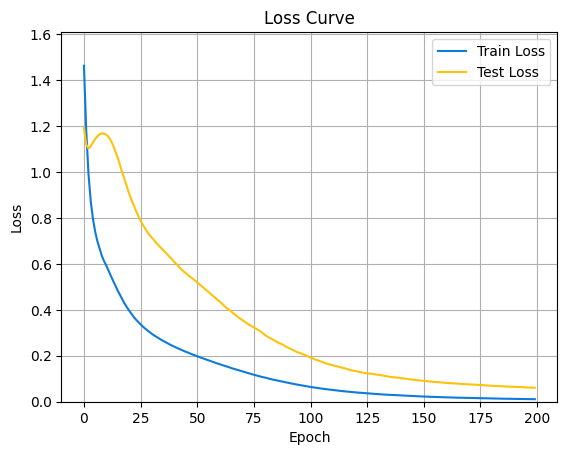

In [10]:
visualizations.plot_loss_curve(training_history.history)

What do you observe? Is the loss going down? Is it going down as quickly for the training dataset as for the test dataset?

Recall the following figure showing common shapes of loss curves.

<img src="https://storage.googleapis.com/dm-educational/assets/ai_foundations/underfitting-overfitting.png">

 Which of these cases resembles your loss curve the most? What does this suggest about your model and the training process?

## Visualizing decision boundaries

You can now also visualize the learned decision boundaries. Do the boundaries seem to separate the three classes properly?

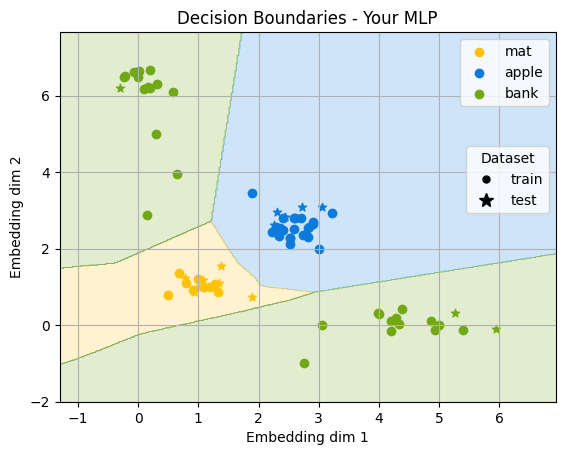

In [11]:
visualizations.plot_data_and_mlp(
    X_train,
    y_train,
    labels,
    features_test=X_test,
    label_ids_test=y_test,
    mlp_model=model,
    title="Decision Boundaries - Your MLP",
)

Your model should be able to separate the dataset nicely. If this is not the case, go back to your implementation of the MLP and verify that it is correct.

## Summary

In this activity, you built your own MLP model for predicting the next token from different prompt embeddings. You created different model structures by changing the layer and neuron numbers. You saw how these changes affected the model performance and how it separated the different classes ("mat", "apple", "bank"). You also generated your first training and test loss curves. This exercise gave you practical experience implementing neural networks, demonstrating firsthand how their structure influences the learning process.

In the upcoming activities, you will learn about additional strategies for verifying that your model is training properly and is not underfitting or overfitting to your training data.


## Solutions

The following cells provide reference solutions to the coding activities in this notebook. If you really get stuck after trying to solve the activities yourself, you may want to consult these solutions.

It is recommended that you *only* look at the solutions after you have tried to solve the activities *multiple times*. The best way to learn challenging concepts in computer science and artificial intelligence is to debug your code piece-by-piece until it works, rather than copying existing solutions.

If you feel stuck, you may want to first try to debug your code. For example, by adding additional print statements to see what your code is doing at every step. This will provide you with a much deeper understanding of the code and the materials. It will also provide you with practice on how to solve challenging coding problems beyond this course.

To view the solutions for an activity, click on the arrow to the left of the activity name. If you consult the solutions, do not copy and paste them into the cells above. Instead, look at them, and type them manually into the cell. This will help you understand where you went wrong.


### Coding Activity 1

In [ ]:
# This defines a complete implementation of the `construct_operations function.`
def construct_operations(hidden_dims: list[int], n_classes: int) -> list[keras.Layer]:
    """
    A function that builds all operations, i.e., weighted sum computations
    and activation functions for an MLP with a SoftMax layer as the output
    layer.

    Args:
      hidden_dims: A list of dimensions for all hidden layers.
      n_classses: Number of classes for the output layer.

    Returns:
      A list of operations in the form of Keras Layer instances.
    """
    operations = []
    for dim in hidden_dims:
        operations.append(keras.layers.Dense(dim))
        operations.append(keras.layers.ReLU())

    operations.append(keras.layers.Dense(n_classes))  # Output layer: n_classes.
    operations.append(keras.layers.Softmax())

    return operations